# Unsupervised Learning - Solution

### MDM - Rafael Caballero

Some people have been using wearable sensors for some period of time. We have information about each person (age,education), information obtained from the sensors and a label that represents what the person is doing (walking, sat down, running....). The sensor information (column names started by p) is discrete and ordinal (values 0,1,2,3...where 1 represents some value bigger than the value represented by 0 and so on). The label can take the values 0,1,2,3,4 and 5

### Setup

In [1]:

import os.path
from subprocess import check_call
import importlib
import os
import sys
import findspark
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

modules = ["findspark","pyspark"]

def check_modules(modules, upgrade=False):
    print("Checking required modules")
    for m in modules:
        torch_loader = importlib.util.find_spec(m)
        if torch_loader is not None and not upgrade:
            print(m," found")
        else:
            if upgrade:
                print("upgrading ",m)
            else:
                print(m," not found, installing")
            if 'google.colab' in sys.modules:
                if upgrade:
                    check_call(["pip", "install", "--upgrade", m])
                else:
                    check_call(["pip", "install", "-q", m])
            else:
                if upgrade:
                    check_call([sys.executable, "-m", "pip", "install", "--user", "--upgrade", m])
                else:
                    check_call([sys.executable, "-m", "pip", "install", "--user", m])


        
check_modules(modules,upgrade=False)

findspark.init()
spark = SparkSession.builder.getOrCreate() # SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.sql('''select 'spark' as hi ''')
df.show()

Checking required modules
findspark  found
pyspark  found
+-----+
|   hi|
+-----+
|spark|
+-----+



Some auxiliary functions

In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline
from pyspark_dist_explore import hist
import pyspark.sql.functions as func 


def load_file(file):
    df = spark.read.format("com.databricks.spark.csv")\
            .options(header='true', inferschema='true') \
            .load(file)
    return df


def evaluate_predictions(predictions,verb=True):
    
    preds_and_labels = predictions.select(['prediction','label'])
    pl = preds_and_labels.rdd.map(tuple)
    metrics = MulticlassMetrics(pl)
    cm = metrics.confusionMatrix()

    # 
    class_temp = predictions.select("label").groupBy("label")\
                            .count().sort('count', ascending=False).toPandas()
    class_names = class_temp["label"].values.tolist()
    
    
    #print(class_names)
    cm = cm.toArray()
    if verb:
        print(cm)
    # add by rows to compute the recall
    sumaf = []
    if verb:
        print("Recall ")
    for i in range(len(class_names)):
        suma = sum(cm[i])
        if verb:
            print(i,':',round(cm[i][i]/suma,2))
        sumaf.append(suma)
              
    # add by columns to compute the precision
    sumac = []
    sumad = []
    if verb:
        print("Precision ")
    for i in range(len(class_names)):
        suma = 0
        for j in range(len(class_names)):
              suma += cm[j][i]
        sumac.append(suma)
        if verb:
            print(i,':',round(cm[i][i]/suma,2))
        sumad.append(cm[i][i])
    oa = np.sum(sumad)/sum(sumac)
    ac = 0
    for i in range(len(sumac)):
        ac += sumac[i]*sumaf[i]
    ac /= (sum(sumac)*sum(sumac))
    #print(oa,ac)
    kappa = (oa-ac)/(1-ac)
    if verb:
        print("***Global Statistics***")        
        print("kappa ",round(kappa,3))
        acc = pl.filter(lambda x: x[0] == x[1]).count() / float(pl.count())
        print("Model accuracy: %.3f%%" % (acc * 100))
    return cm,kappa


Load the data file

In [9]:
url = "https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/datav.csv"
file = "./datav.csv"

import urllib.request

f = urllib.request.urlretrieve(url,file ) # in case of error download manually and comment this line
# lo cargamos como un dataframe
df = load_file(file)
print(f"{df.count()} rows")
df.printSchema()

730 rows
root
 |-- sex: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- hab: integer (nullable = true)
 |-- prov: integer (nullable = true)
 |-- ccaa: integer (nullable = true)
 |-- edu: integer (nullable = true)
 |-- cs: integer (nullable = true)
 |-- p1_1: integer (nullable = true)
 |-- p1_2: integer (nullable = true)
 |-- p1_3: integer (nullable = true)
 |-- p1_4: integer (nullable = true)
 |-- p1_5: integer (nullable = true)
 |-- p1_6: integer (nullable = true)
 |-- p1_7: integer (nullable = true)
 |-- p1_8: integer (nullable = true)
 |-- p1_9: integer (nullable = true)
 |-- p1_10: integer (nullable = true)
 |-- p2_1: integer (nullable = true)
 |-- p2_2: integer (nullable = true)
 |-- p2_3: integer (nullable = true)
 |-- p3_1: integer (nullable = true)
 |-- p3_2: integer (nullable = true)
 |-- p3_3: integer (nullable = true)
 |-- p3_4: integer (nullable = true)
 |-- p3_5: integer (nullable = true)
 |-- p3_6: integer (nullable = true)
 |-- p4_1: integer (nullable 

#### Exercise 1 (2 points). 

First we are going to use unsupervised learning and group the data into 5 groups. The idea is to check if the groups have some relation with the label, that is if the features correspond geometrically to the label.

In particular we are going to use k-means with k=5

In [10]:
from pyspark.ml.clustering import KMeans
k = 5 # number of clusters (groups)
method = KMeans().setK(k).setSeed(1) # don't change this!!

The variable `method` will be the second step of a pipeline. The first step will be the usual `VectorAssembler` that combines in a single column `features` al the columns except `label`.

Write the pipeline and apply it to dataframe `df`, storing the result in a variable `predictions`

*Important*: in unsupervised learning there is no need of dividing the data between train and test: both the *fit* and the *transform* are applied to the whole dataframe

In [21]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

### solution
vectorcols = [x for x in df.columns if x not in ['label']]

# 
assembler = VectorAssembler(
    inputCols=vectorcols,
    outputCol='features')



pipeline = Pipeline(stages=[assembler,method])

# Make predictions
predictions = pipeline.fit(df).transform(df)

#scaler = MinMaxScaler(inputCol="featuresi",outputCol="features")

The column `prediction` represent the cluster number assigned by kmeans and is a number from 0 to 4; the rows with the smae number have been assigned to the same cluster. These values are not related to the label, that has not been used so far:

In [22]:
predictions.select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|    3|         1|
|    0|         0|
|    2|         3|
|    0|         0|
|    1|         4|
|    1|         3|
|    2|         3|
|    3|         3|
|    0|         4|
|    1|         3|
|    0|         4|
|    4|         3|
|    4|         4|
|    3|         4|
|    1|         1|
|    4|         1|
|    0|         3|
|    1|         4|
|    4|         2|
|    3|         3|
+-----+----------+
only showing top 20 rows



#### Exercise 2 (2 points). 

For each cluster value (column `prediction`) we would like to know how the values of the label are distributed. 

Complete the function `show_clusters` such that  for each value c between 0 and k (not included) of `prediction`:

a) Obtains a dataframe df_c containing only those rows of `df` with  `prediction` equal to `c` (use filter [filter](https://sparkbyexamples.com/pyspark/pyspark-where-filter/))

b) Call to the histogram function to show the histogram of column `label` in `df_c`.

Cluster 0


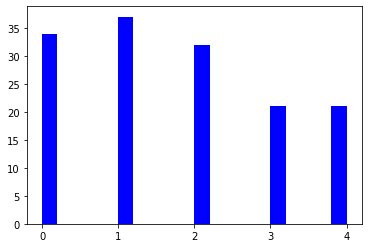

Cluster 1


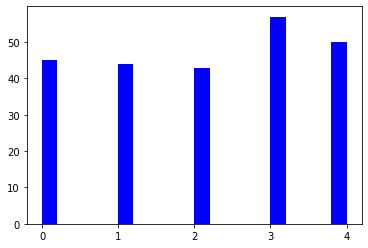

Cluster 2


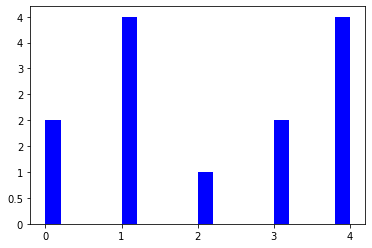

Cluster 3


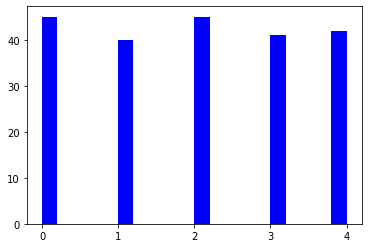

Cluster 4


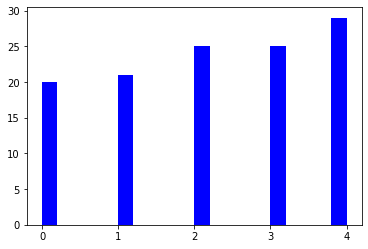

In [24]:
def histogram(df,col,bins=20,color="blue"):
    fig,ax = plt.subplots()
    hist(ax, df.select([col]), bins = bins, color=[color])
    plt.xticks(range(5), range(5))
    plt.show()
    
def show_clusters(predictions,k):  
    # solution
    for c in range(0,k):
        # elements in cluster p
        print(f"Cluster {c}")
        df_c = predictions.filter(predictions.prediction==c)
        histogram(df_c,"label")
        
# test
show_clusters(predictions,k)

#### Exercise 3 (2 points).  

The results are very disappointing:  the cluster do not seem to be related to the label. Are we doing anything wrong?

Thinking about the problem we remember that scaling the data can be important in geometrical methods. We decide to use the MinMaxScaler, a scaler that converts all the values to the range [0,1]. This will be a new step in the pipeline, that scales all the values except the `label`. As usual the result will be called  `predictions`.

Cluster 0


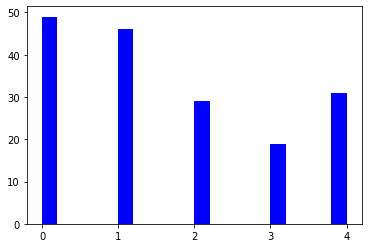

Cluster 1


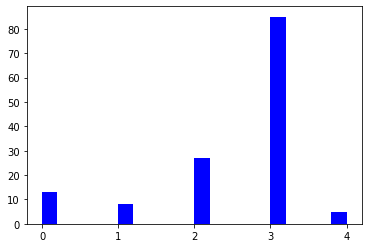

Cluster 2


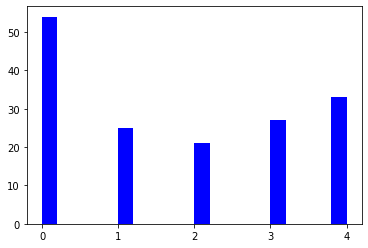

Cluster 3


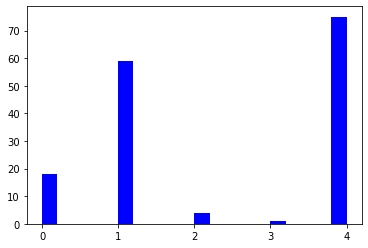

Cluster 4


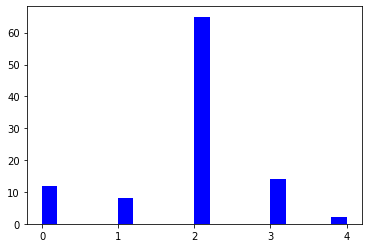

In [25]:
from pyspark.ml.feature import MinMaxScaler

# solution
assembler = VectorAssembler(
    inputCols=vectorcols,
    outputCol='featuresi')

method = KMeans().setK(k).setSeed(1)
scaler = MinMaxScaler(inputCol="featuresi",outputCol="features")
pipeline = Pipeline(stages=[assembler,scaler,method])

# Make predictions
predictions = pipeline.fit(df).transform(df)


### test
show_clusters(predictions,k)

#### Exercise 4 (2 points).    

This is much better. Now it seems that some label values are related to some clusters. 

Now we get new information: some sensors represent categorical data (for instance the orientationnorth, south, east and west) and therefore we should not apply the scaler. Instead we will apply a `OneHotEncoder`.

In the next code, variable `cols_codify` contains the name of these categorical columns, while `cols_codify_newnames` are the new names obtained after applying the `OneHotEncoder`. Additionally, the variable `vectorcols` contains the list of column names that now the VectorAssembler must use. This list is the list of features but replacing the names of the categorical data by the new names.

Design and apply the new  pipeline with all the elements. The scaler is still a part of the pipeline, sincbe it will be applied to the rest of the variable and have no influence on the variable encoded by  OneHotEncoder.

Cluster 0


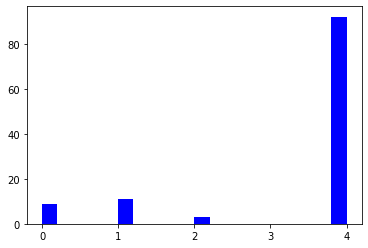

Cluster 1


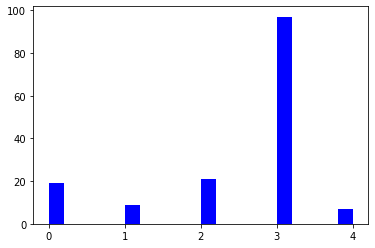

Cluster 2


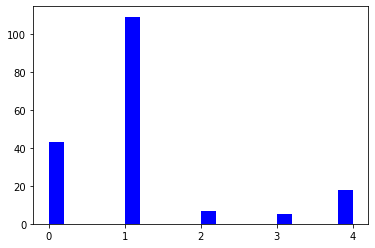

Cluster 3


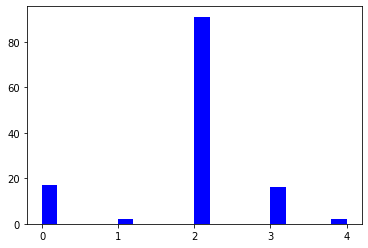

Cluster 4


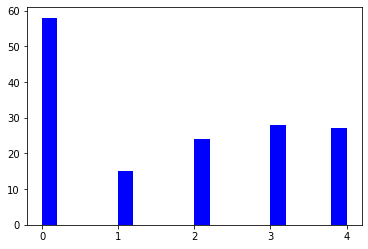

In [26]:
from pyspark.ml.feature import OneHotEncoder

cols_codify = ["p5_1","p5_2","p5_3","p5_4","p5_5","p5_6","p5_7","p5_8","p5_9","p5_10","p5_11","p5_12","prov","ccaa"]
cols_codify_newnames = [x+"_t" for x in cols_codify]

vectorcols = [x if x not in cols_codify else x+"_t" for x in df.columns if x not in ['label']]

#### Solution
encoder = OneHotEncoder(inputCols=cols_codify,
                        outputCols=cols_codify_newnames)
# vector
assembler = VectorAssembler(
    inputCols=vectorcols,
    outputCol='featuresi')

# scaler
scaler = MinMaxScaler(inputCol="featuresi",outputCol="features")

method = KMeans().setK(k).setSeed(1)
pipeline = Pipeline(stages=[encoder,assembler,scaler,method])

# Make predictions
predictions = pipeline.fit(df).transform(df)

show_clusters(predictions,k)

#### Exercise 5 (2 points). 

Now we can see that finally the cluster represent (approx.) the values of the label. Then, could we deduce the lavel from the sensor and the ersonal data? Emply a RandomForest classifier for predicting the label from the rest of the columns. Once more the result will be called `predictions`

Important: We are back in supervised learning, and thus it is important to use a traing and a test set

In [27]:
from pyspark.ml.classification import RandomForestClassifier

# this is needed because raendomforest assumes that label is a double
from pyspark.sql.functions import col
df = df.withColumn("label",df.label.cast('double'))

# train  & test proportion
ratio_train=0.65


#####solution
splits = df.randomSplit([ratio_train, 1-ratio_train],1234)
train_df = splits[0]
test_df = splits[1]

method = RandomForestClassifier()
pipeline = Pipeline(stages=[encoder,assembler,scaler,method])

model = pipeline.fit(train_df)
predictions = model.transform(test_df)


###### Test
cm,kappa = evaluate_predictions(predictions,verb=False)
print(cm)
print(f"Kappa {kappa}")

C:\Users\Rafa\AppData\Roaming\Python\Python38\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[23. 13.  6.  0.  7.]
 [ 7. 36.  2.  2.  7.]
 [14.  2. 29.  5.  0.]
 [ 9.  0.  7. 33.  0.]
 [11.  4.  2.  0. 38.]]
Kappa 0.5232001211593436
